In [1]:
# Import the dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Visualize the Stations
sel=[Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
stations = session.query(*sel).all()
for station in stations:
    print(station)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


In [11]:
# Visualize some rows of Measurement
sel=[Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurements = session.query(*sel).limit(10).all()
for measurement in measurements:
    print(measurement)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)
(10, 'USC00519397', '2010-01-11', 0.01, 64.0)


# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
last_date = last_date[0][0]
last_date = dt.date( int(last_date.split("-")[0]), 
                     int(last_date.split("-")[1]),
                     int(last_date.split("-")[2]) 
                   )
# Calculate the date to filter one year
dt_filter = last_date - dt.timedelta(days=364)


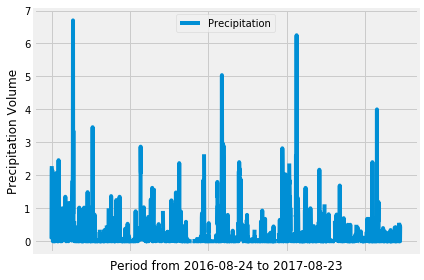

In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
prcp_last_12_months = session.query(*sel).\
    filter(Measurement.date >= dt_filter.strftime("%Y-%m-%d")).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_last_12_months, columns=['date','prcp'])
df.rename(columns = {"prcp": "Precipitation"}, inplace = True)

# Sort the dataframe by date
df.sort_values('date', inplace=True)

#Set the index to the date column
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.ylabel("Precipitation Volume")
plt.xlabel("Period from " + str(dt_filter) + " to " + str(last_date))
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()


In [14]:
# Print the summary statistics for the precipitation data.
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis 

In [15]:
# Query to show how many stations are available in this dataset?
sel = [func.count(func.distinct(Station.station)).label("number_of_stations")]
total_stations = session.query(*sel).all()
print(total_stations[0].number_of_stations)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,  
      func.count(Measurement.station)]
count_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station in count_station:
    print(station)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id = count_station[0].station

sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)
      ]
stats_most_active_station = session.query(*sel).\
    filter(Measurement.station == most_active_station_id).\
    group_by(Measurement.station).all()
    
print(stats_most_active_station)


[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [18]:
# Choose the station with the highest number of temperature observations.
sel = [Measurement.station, func.count(func.distinct(Measurement.tobs))]
highest_temperat_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(func.distinct(Measurement.tobs)).desc()).all()

for row in highest_temperat_station: 
    print (row)

# Get the id of the station with the highest number of temperature observations     
highest_num_temp_station = highest_temperat_station[0][0]

# highest_num_temp_station = most_active_station_id
print(highest_num_temp_station)
    

('USC00511918', 34)
('USC00519281', 31)
('USC00519397', 30)
('USC00519523', 30)
('USC00517948', 28)
('USC00513117', 27)
('USC00516128', 27)
('USC00514830', 26)
('USC00518838', 25)
USC00511918


In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the last date for the station
result = session.query(func.max(Measurement.date).label("max_date")).\
    filter(Measurement.station == highest_num_temp_station).all()

# Calculate the date to filter the last year
last_date = result[0].max_date
last_date = dt.date( int(last_date.split("-")[0]), 
                     int(last_date.split("-")[1]),
                     int(last_date.split("-")[2]) 
                   )
dt_filter = last_date - dt.timedelta(days=364)

# Get the temperatures 
temperatures = session.query(Measurement.tobs).\
    filter(Measurement.station == highest_num_temp_station,
    Measurement.date >= dt_filter.strftime("%Y-%m-%d")).all() 

for row in temperatures: 
    print (row)

(76.0,)
(78.0,)
(73.0,)
(70.0,)
(72.0,)
(66.0,)
(75.0,)
(75.0,)
(76.0,)
(71.0,)
(78.0,)
(68.0,)
(67.0,)
(69.0,)
(75.0,)
(76.0,)
(64.0,)
(74.0,)
(78.0,)
(74.0,)
(75.0,)
(70.0,)
(72.0,)
(69.0,)
(68.0,)
(73.0,)
(77.0,)
(75.0,)
(77.0,)
(70.0,)
(62.0,)
(68.0,)
(67.0,)
(70.0,)
(66.0,)
(64.0,)
(62.0,)
(64.0,)
(63.0,)
(69.0,)
(64.0,)
(70.0,)
(72.0,)
(72.0,)
(64.0,)
(71.0,)
(68.0,)
(81.0,)
(78.0,)
(69.0,)
(72.0,)
(70.0,)
(62.0,)
(76.0,)
(72.0,)
(76.0,)
(57.0,)
(64.0,)
(57.0,)
(66.0,)
(65.0,)
(69.0,)
(62.0,)
(56.0,)
(63.0,)
(57.0,)
(57.0,)
(62.0,)
(77.0,)
(66.0,)
(63.0,)
(60.0,)
(72.0,)
(74.0,)
(69.0,)
(70.0,)
(74.0,)
(63.0,)
(67.0,)
(61.0,)
(66.0,)
(67.0,)
(72.0,)
(68.0,)
(66.0,)
(59.0,)
(68.0,)
(74.0,)
(60.0,)
(65.0,)
(72.0,)
(76.0,)
(74.0,)
(75.0,)
(73.0,)
(64.0,)
(75.0,)
(71.0,)
(71.0,)
(62.0,)
(63.0,)
(68.0,)
(62.0,)
(63.0,)
(65.0,)
(69.0,)
(63.0,)
(73.0,)
(66.0,)
(63.0,)
(69.0,)
(65.0,)
(71.0,)
(78.0,)
(75.0,)
(71.0,)
(73.0,)
(67.0,)
(71.0,)
(68.0,)
(69.0,)
(72.0,)
(73.0,)
(69.0,)
(71.0,)


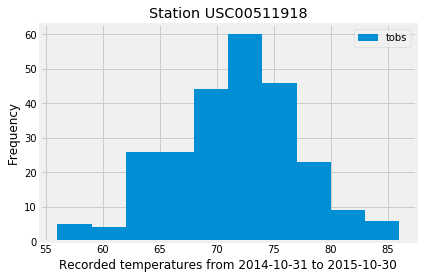

In [20]:
# Plot the histogram
df_temp = pd.DataFrame(temperatures)
df_temp.plot.hist()
plt.xlabel('Recorded temperatures from ' + str(dt_filter) + " to " + str(last_date))
plt.ylabel('Frequency')
plt.title('Station ' + highest_num_temp_station)
plt.grid(True)
plt.show()

In [38]:

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs).label("minimum"),  
                         func.avg(Measurement.tobs).label("average"),  
                         func.max(Measurement.tobs).label("maximum")) .\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Define my period to trip
trip_start = dt.date(2017, 8, 1)  
trip_end = dt.date(2017, 8, 14) 

# Back one year
prev_start = trip_start - dt.timedelta(days=365)
prev_end = trip_end - dt.timedelta(days=365)

stats_temp_trip = calc_temps(prev_start, prev_end) 
print (stats_temp_trip)



[(71.0, 78.21111111111111, 83.0)]


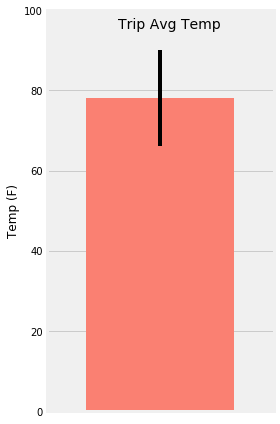

In [135]:
# Plot the results from your previous query as a bar chart.
fig, ax = plt.subplots(figsize=(4,6))

# Use "Trip Avg Temp" as your Title
fig.suptitle("Trip Avg Temp", fontsize=14, fontweight="light", x=0.6, y=0.95)

# Use the average temperature for the y value
y = stats_temp_trip[0].average
x = 0

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = stats_temp_trip[0].maximum - stats_temp_trip[0].minimum

ax.set_ylabel("Temp (F)")

ax.bar(x, y, width=1.3, color="salmon", yerr=y_err)
ax.set_ylim(0, 100)
ax.set_xticks([])
ax.set_xbound(lower=-1, upper=1)
plt.grid(True)
fig.tight_layout()
plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
